<a href="https://colab.research.google.com/github/mobinapourmoshir/Deep-Learning/blob/main/Denoising_Autoencoder_Different_noises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Denoising Autoencoder**

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5068 - val_loss: 0.3550
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3448 - val_loss: 0.3352
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3306 - val_loss: 0.3283
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.3238 - val_loss: 0.3235
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.3197 - val_loss: 0.3198
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3166 - val_loss: 0.3171
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3138 - val_loss: 0.3154
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3112 - val_loss: 0.3128
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3094 - val_loss: 0.3113
Epoch 10/50
235/235 ━━━━━━━━━━

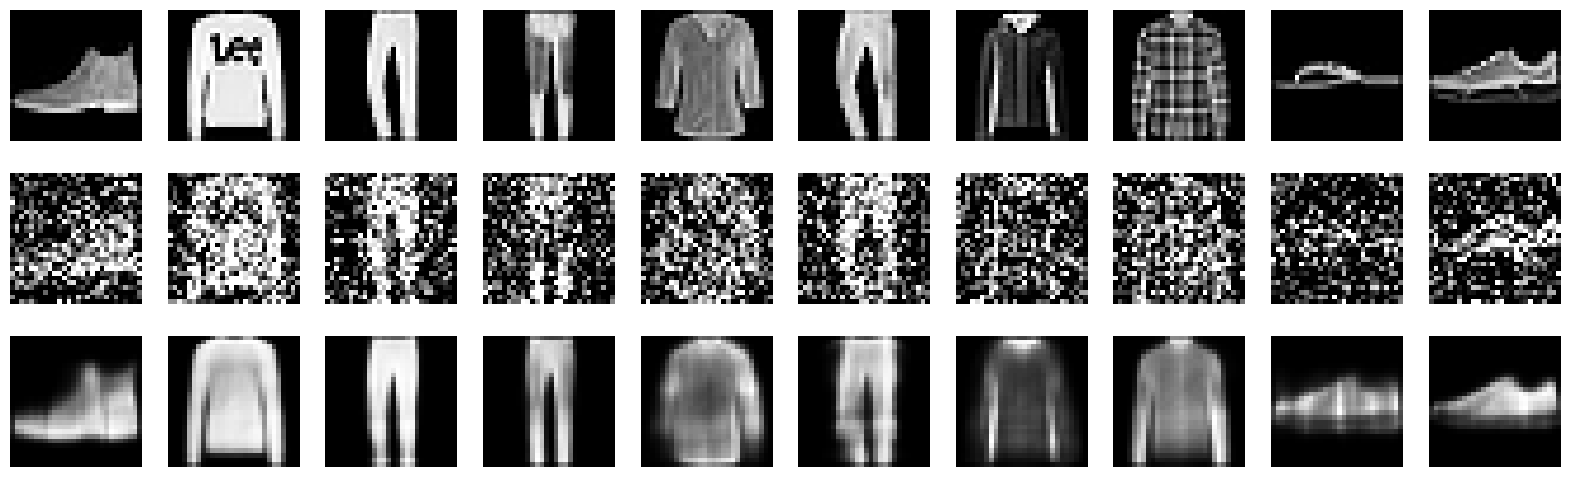

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train_flat = x_train.reshape(len(x_train), 784)
x_test_flat = x_test.reshape(len(x_test), 784)

n = 10
encoding_dim = 32
input_img = tf.keras.Input(shape=(784,))
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

denoising_autoencoder = tf.keras.Model(input_img, decoded)
denoising_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

noise_factor = 0.5
x_train_noisy = x_train_flat + noise_factor * \
    np.random.normal(loc=0.0, scale=1.0, size=x_train_flat.shape)
x_test_noisy = x_test_flat + noise_factor * \
    np.random.normal(loc=0.0, scale=1.0, size=x_test_flat.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

denoising_autoencoder.fit(x_train_noisy, x_train_flat,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test_flat))

decoded_imgs = denoising_autoencoder.predict(x_test_noisy)

plt.figure(figsize=(20, 6))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_flat[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()

In [2]:
# Defining MSE function
def mse(a, b):
    return np.mean((a - b) ** 2)

# MSE for the normal (Gaussian) noise test
mse_normal = mse(decoded_imgs, x_test_flat)
print(f"MSE (Normal Gaussian noise): {mse_normal:.5f}")

MSE (Normal Gaussian noise): 0.01916


Test on different types of noises: skewed-normal & salt-and-pepper (impulse)

MSE (Skewed-normal noise): 0.10200
MSE (Salt & Pepper noise): 0.01863


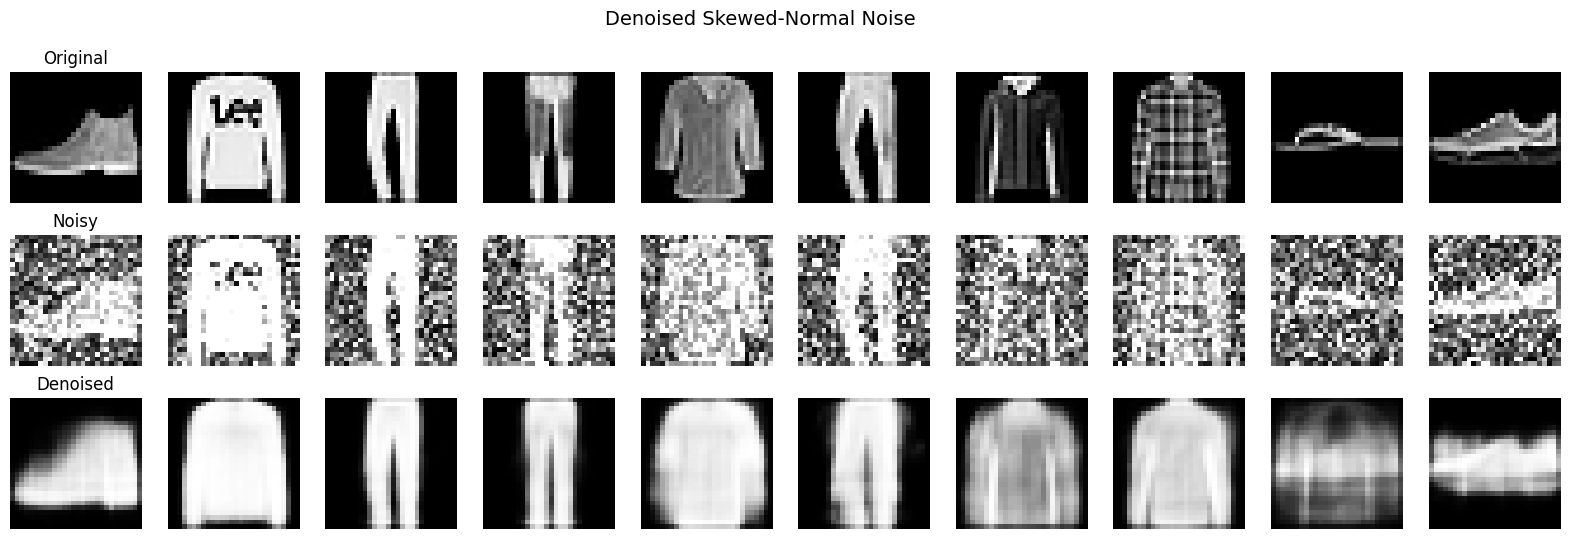

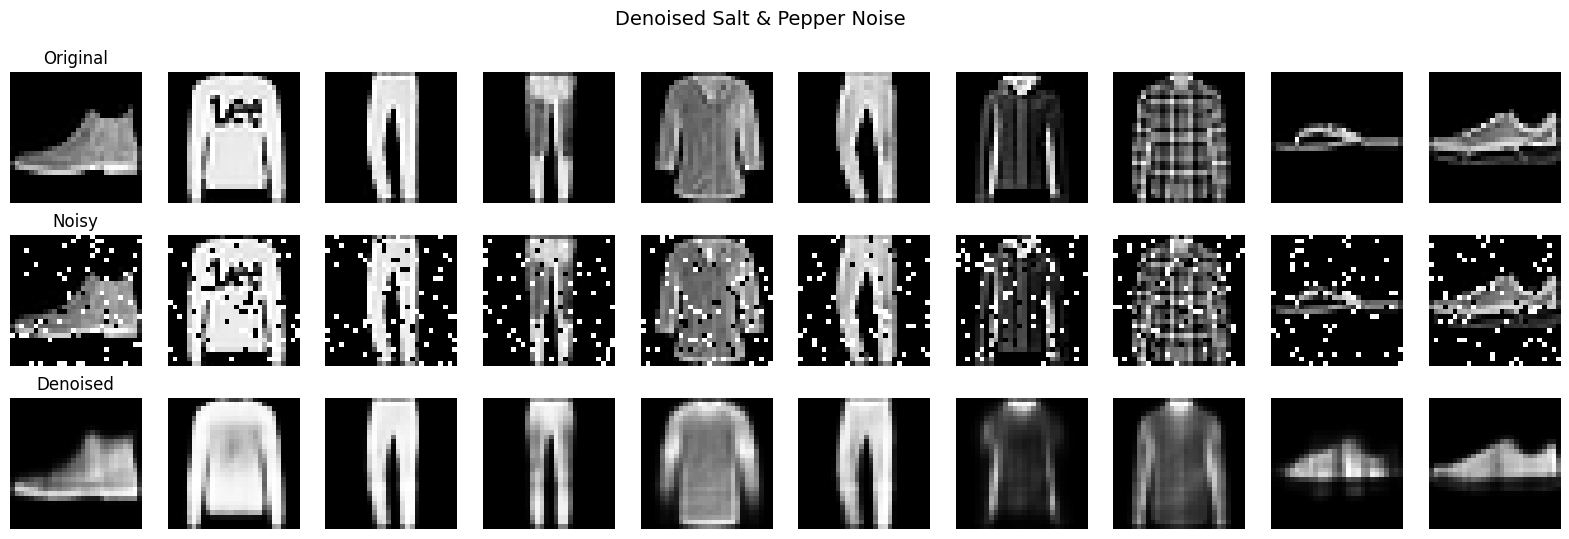

In [16]:
import numpy as np
from scipy.stats import skewnorm

# Defining Skewed normal noise
def add_skewed_normal_noise(x_flat, noise_factor=0.5, skew=10.0, loc=0.1, scale=1.0, clip=True):
    """
    x_flat: (N, 784) in [0,1]
    noise_factor: multiplier for noise magnitude
    skew: shape param 'a' for skew-normal (>0 = right-skew, <0 = left-skew)
    """
    noise = skewnorm.rvs(a=skew, loc=loc, scale=scale, size=x_flat.shape, random_state=None)
    x_noisy = x_flat + noise_factor * noise
    if clip:
        x_noisy = np.clip(x_noisy, 0., 1.) # Range between 0 and 1
    return x_noisy

# Defining Salt & Pepper noise
def add_salt_pepper_noise(x_flat, amount=0.1, salt_vs_pepper=0.5):
    """
    x_flat: (N, 784) in [0,1]
    amount: fraction of pixels to corrupt (0..1)
    salt_vs_pepper: proportion of 'salt' (1.0) vs 'pepper' (0.0)
    """
    x_noisy = x_flat.copy()
    N, D = x_noisy.shape
    num_corrupt = int(amount * D)

    rng = np.random.default_rng() # new random number generator (RNG)
    # indices to flip per image
    for i in range(N):
        idx = rng.choice(D, size=num_corrupt, replace=False)
        # split into salt and pepper
        k_salt = int(salt_vs_pepper * num_corrupt) # Number of salt noises
        salt_idx = idx[:k_salt] # Salt indices
        pepper_idx = idx[k_salt:] # Pepper indices
        x_noisy[i, salt_idx] = 1.0
        x_noisy[i, pepper_idx] = 0.0
    return x_noisy

# Create noisy test sets (for evaluation)
noise_factor = 0.5
x_test_skew = add_skewed_normal_noise(x_test_flat, noise_factor=noise_factor, skew=10.0)
x_test_sp   = add_salt_pepper_noise(x_test_flat, amount=0.15, salt_vs_pepper=0.5)

# Denoise with our trained model
decoded_skew = denoising_autoencoder.predict(x_test_skew, verbose=0) # verbose=0: No output is printed.
decoded_sp   = denoising_autoencoder.predict(x_test_sp,   verbose=0)

# Calculating MSE
mse_skew = mse(decoded_skew, x_test_flat)
mse_sp   = mse(decoded_sp,   x_test_flat)
print(f"MSE (Skewed-normal noise): {mse_skew:.5f}")
print(f"MSE (Salt & Pepper noise): {mse_sp:.5f}")

# Visualization
n = 10
def show_triplets(x_clean, x_noisy, x_decoded, title):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20, 6))
    plt.suptitle(title, fontsize=14)
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_clean[i].reshape(28, 28), cmap='gray')
        ax.set_title("Original" if i == 0 else "")
        ax.axis('off')

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(x_noisy[i].reshape(28, 28), cmap='gray')
        ax.set_title("Noisy" if i == 0 else "")
        ax.axis('off')

        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(x_decoded[i].reshape(28, 28), cmap='gray')
        ax.set_title("Denoised" if i == 0 else "")
        ax.axis('off')
    plt.show()

show_triplets(x_test_flat, x_test_skew, decoded_skew, "Denoised Skewed-Normal Noise")
show_triplets(x_test_flat, x_test_sp,   decoded_sp,   "Denoised Salt & Pepper Noise")
